## Text Analysis on Great Expectations

#### Pulling text data

In [1]:
# import libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

import pandas as pd
from PIL import Image
import numpy as np
import random
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('vader_lexicon')
# nltk.download('wordnet')

#### Pulling text data

In [3]:
# Opens novel text file
with open("sense_and_sensibility.txt", mode="r", encoding="utf-8") as f:
    content = f.read()


In [4]:
print(content)

The Project Gutenberg eBook of Sense and Sensibility
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Sense and Sensibility

Author: Jane Austen

Release date: September 1, 1994 [eBook #161]
                Most recently updated: March 16, 2021

Language: English



*** START OF THE PROJECT GUTENBERG EBOOK SENSE AND SENSIBILITY ***

[Illustration]




Sense and Sensibility

by Jane Austen

(1811)


Contents

 CHAPTER I
 CHAPTER II
 CHAPTER III
 CHAPTER IV
 CHAPTER V
 CHAPTER VI
 CHAPTER VII
 CHAPTER VIII
 CHAPTER IX
 CHAPTER X
 CHAPTER XI
 CHAPTER XII
 CHAPTER XIII
 CHAPTER XIV
 CHAPTER

#### Cleaning text data

In [5]:
# lowercase words for word cloud.
word_cloud_text = content.lower()

# Remove numvers and alphanumeric words we don't need for word cloud.
word_cloud_text = re.sub("[^a-zA-Z0-9]", " ", word_cloud_text)

In [6]:
# Tokenize the data to split it into words
tokens = word_tokenize(word_cloud_text)

# Remove stopwords (words with minimal meaning - the, and, is.)
tokens = (word for word in tokens if word not in stopwords.words("english"))

# Remove short words (less than 3 characters)
tokens = (word for word in tokens if len(word)  >= 3)

In [7]:
# Data cleaning to split data into sentences
alphabets = "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s" \
           "|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][].](?:[A-Z][.]?))"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"

text = f" {content} "
text = text.replace("\n", " ")
text = re.sub(prefixes, "\\1<prd>", text)
text = re.sub(websites, "<prd>\\1", text)
text = re.sub(digits + "[.]" + digits, "\\1<prd>\\2", text)
if "..." in text: text = text.replace("...", "<prd><prd><prd>")
if "Ph.D" in text: text = text.replace("Ph.D.", "Ph<prd>D<prd>")
text = re.sub("\s" + alphabets + "[.] ", " \\1<prd> ", text)
text = re.sub(acronyms + " " + starters, "\\1<stop> \\2", text)
text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]", "\\1<prd>\\2<prd>\\3<prd>", text)
text = re.sub(alphabets + "[.]" + alphabets + "[.]", "\\1<prd>\\2<prd>", text)
text = re.sub(" " + suffixes + "[.] " + starters, " \\1<stop> \\2", text)
text = re.sub(" " + suffixes + "[.]", " \\1<prd>", text)
text = re.sub(" " + alphabets + "[.]", " \\1<prd>", text)
if "”" in text: text = text.replace(".”", "”.")
if "\"" in text: text = text.replace(".\"", "\".")
if "!" in text: text = text.replace("!\"", "\"!")
if "?" in text: text = text.replace("?\"", "\"?")
text = text.replace(".", ".<stop>")
text = text.replace("?", "?<stop>")
text = text.replace("!", "!<stop>")
text = text.replace("<prd>", ".")
sentences = text.split("<stop>")
sentences = [s.strip() for s in sentences]
sentences = pd.DataFrame(sentences)
sentences.columns = ['sentence']

In [8]:
# Print out length and first 10 rows of sentences variable
print(len(sentences))
print(sentences.head(10))

5441
                                            sentence
0  The Project Gutenberg eBook of Sense and Sensi...
1  You may copy it, give it away or re-use it und...
2                                     gutenberg.org.
3  If you are not located in the United States, y...
4  Title: Sense and Sensibility  Author: Jane Aus...
5  Their estate was large, and their residence wa...
6  The late owner of this estate was a single man...
7  But her death, which happened ten years before...
8  In the society of his nephew and niece, and th...
9              His attachment to them all increased.


In [9]:
# Remove the first few rows of text that are irrelevant for analysis
sentences.drop(sentences.index[:59], inplace=True)
sentences = sentences.reset_index(drop=True)
sentences.head(10)

,sentence
0,A continuance in a place where everything remi...
1,"In seasons of cheerfulness, no temper could be..."
2,But in sorrow she must be equally carried away...
3,Mrs. John Dashwood did not at all approve of w...
4,To take three thousand pounds from the fortune...
5,She begged him to think again on the subject.
6,How could he answer it to himself to rob his c...
7,And what possible claim could the Miss Dashwoo...
8,It was very well known that no affection was e...
9,"“It was my father’s last request to me,” repli..."


#### Creating a Word Cloud

(-0.5, 399.5, 199.5, -0.5)

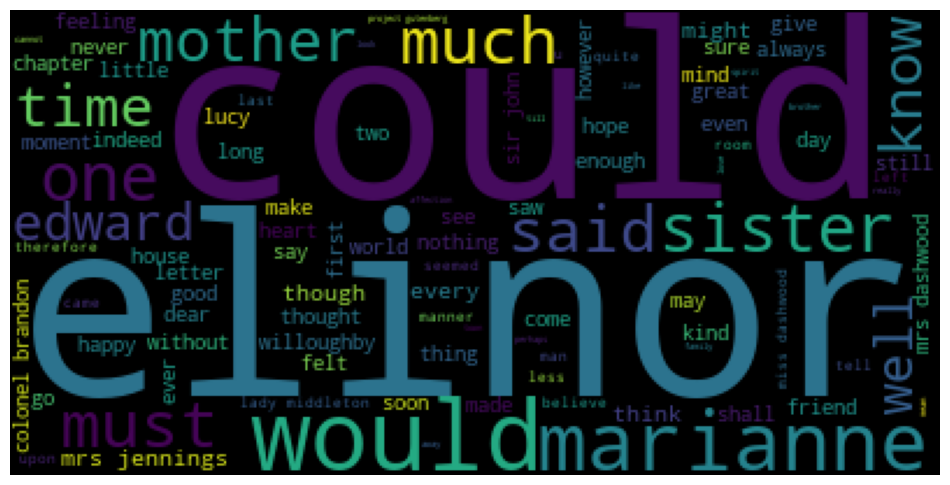

In [10]:
# Word Cloud: A cisual representation of words in a set of text data
stopwords_wc = set(stopwords.words("english"))

word_cloud = WordCloud(max_words=100, stopwords=stopwords_wc, random_state=1).generate(word_cloud_text)
plt.figure(figsize=(12,16))
plt.imshow(word_cloud)
plt.axis("off")

#### Improving the word cloud

In [12]:
# Define gray_color_func function and mask variable for advanced word cloud
mask = np.array(Image.open("ss.jpg"))
def gray_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60,100)

(-0.5, 210.5, 226.5, -0.5)

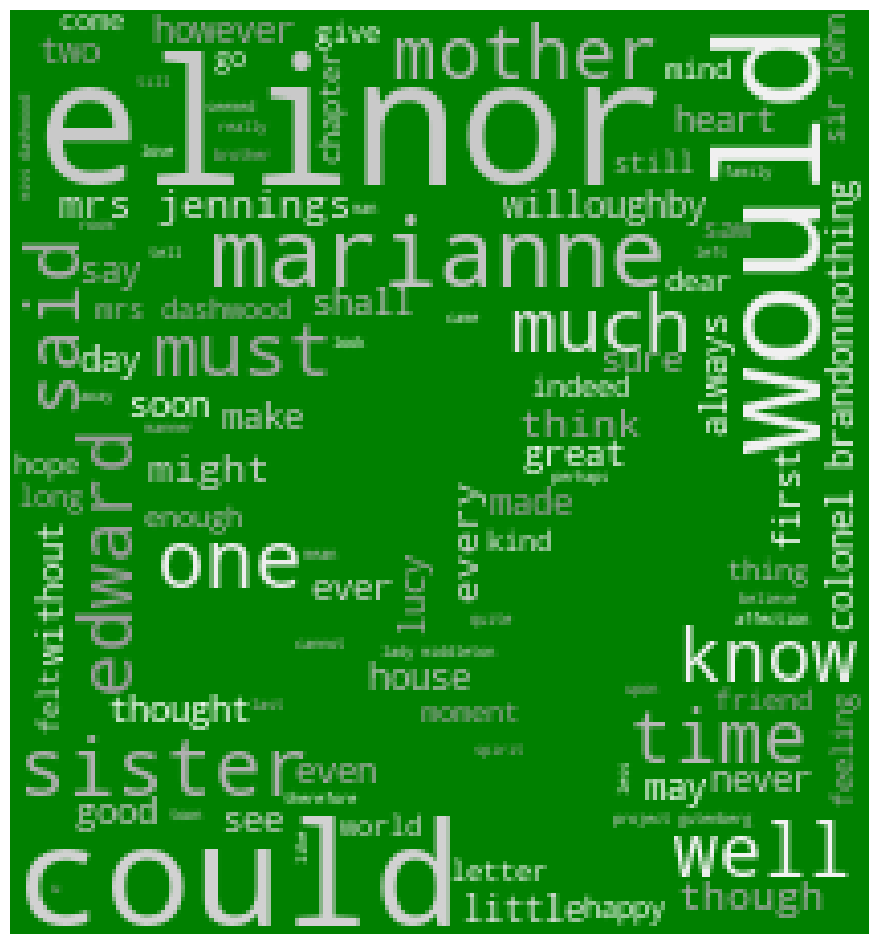

In [17]:
# Create advanced Word Cloud with our text data
word_cloud_advanced = WordCloud(background_color="green", max_words=100, mask=mask, color_func=gray_color_func, stopwords=stopwords_wc, random_state=1).generate(word_cloud_text)
plt.figure(figsize=(16,12))
plt.imshow(word_cloud_advanced)
plt.axis("off")

### Analyzing word frequency

In [18]:
# Create word frequency distribution
f_dist = nltk.FreqDist(tokens)
f_dist

FreqDist({'elinor': 685, 'could': 579, 'marianne': 566, 'mrs': 530, 'would': 515, 'said': 397, 'every': 376, 'one': 333, 'must': 293, 'much': 291, ...})

In [20]:
# View the 50 most frequent words in the text
f_dist.most_common(40)

[('elinor', 685),
 ('could', 579),
 ('marianne', 566),
 ('mrs', 530),
 ('would', 515),
 ('said', 397),
 ('every', 376),
 ('one', 333),
 ('must', 293),
 ('much', 291),
 ('sister', 282),
 ('edward', 263),
 ('mother', 259),
 ('dashwood', 252),
 ('well', 240),
 ('time', 239),
 ('jennings', 235),
 ('know', 233),
 ('though', 216),
 ('willoughby', 216),
 ('might', 215),
 ('think', 210),
 ('miss', 210),
 ('may', 190),
 ('nothing', 189),
 ('never', 189),
 ('lucy', 186),
 ('thing', 184),
 ('without', 183),
 ('soon', 181),
 ('good', 178),
 ('see', 176),
 ('colonel', 176),
 ('ever', 169),
 ('john', 164),
 ('house', 160),
 ('little', 160),
 ('say', 160),
 ('first', 159),
 ('however', 156)]

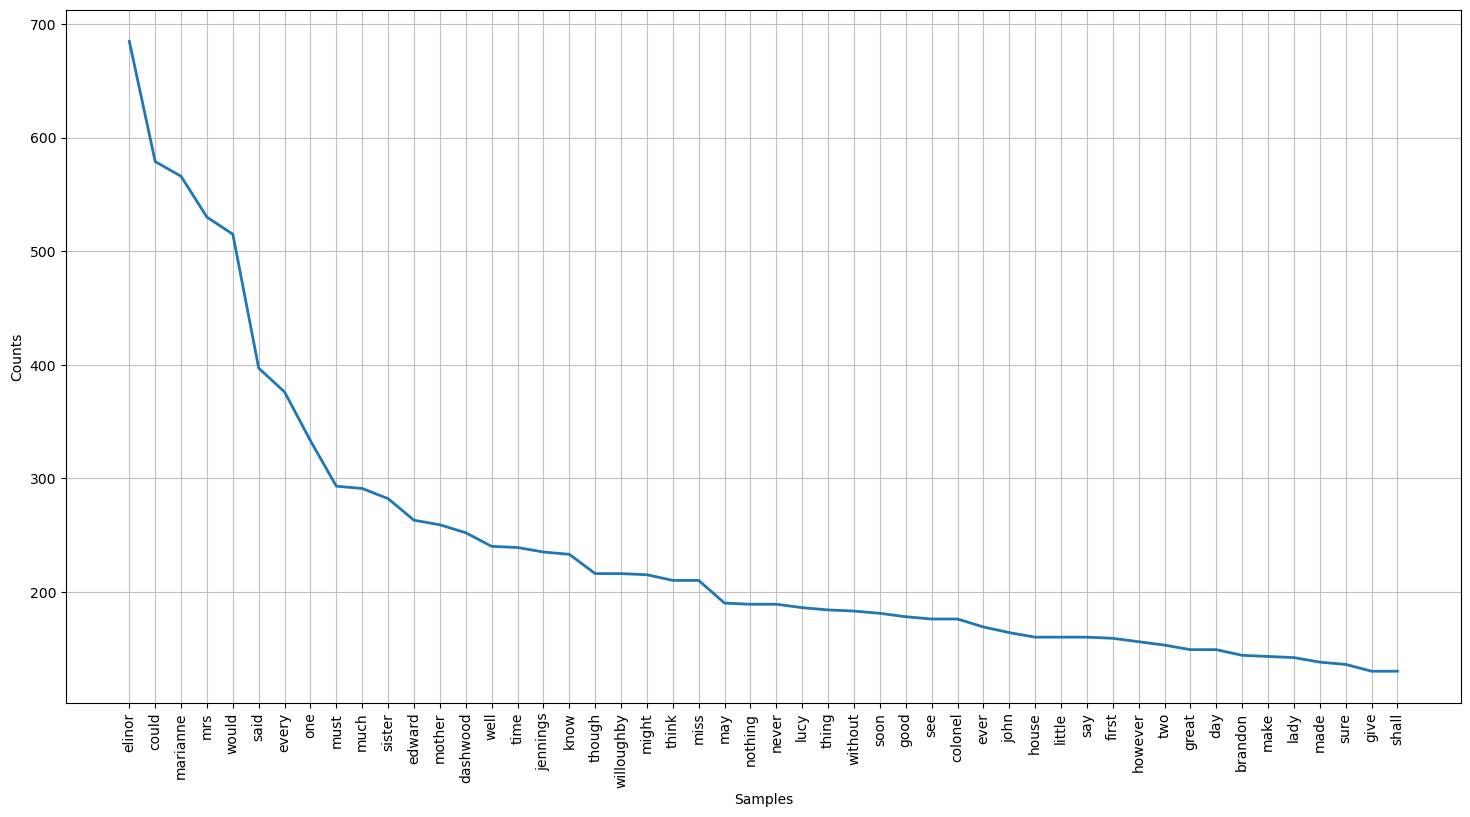

<Axes: xlabel='Samples', ylabel='Counts'>

In [21]:
# Visualization of 40 most frequent words
plt.figure(figsize=(18,9))
f_dist.plot(50)

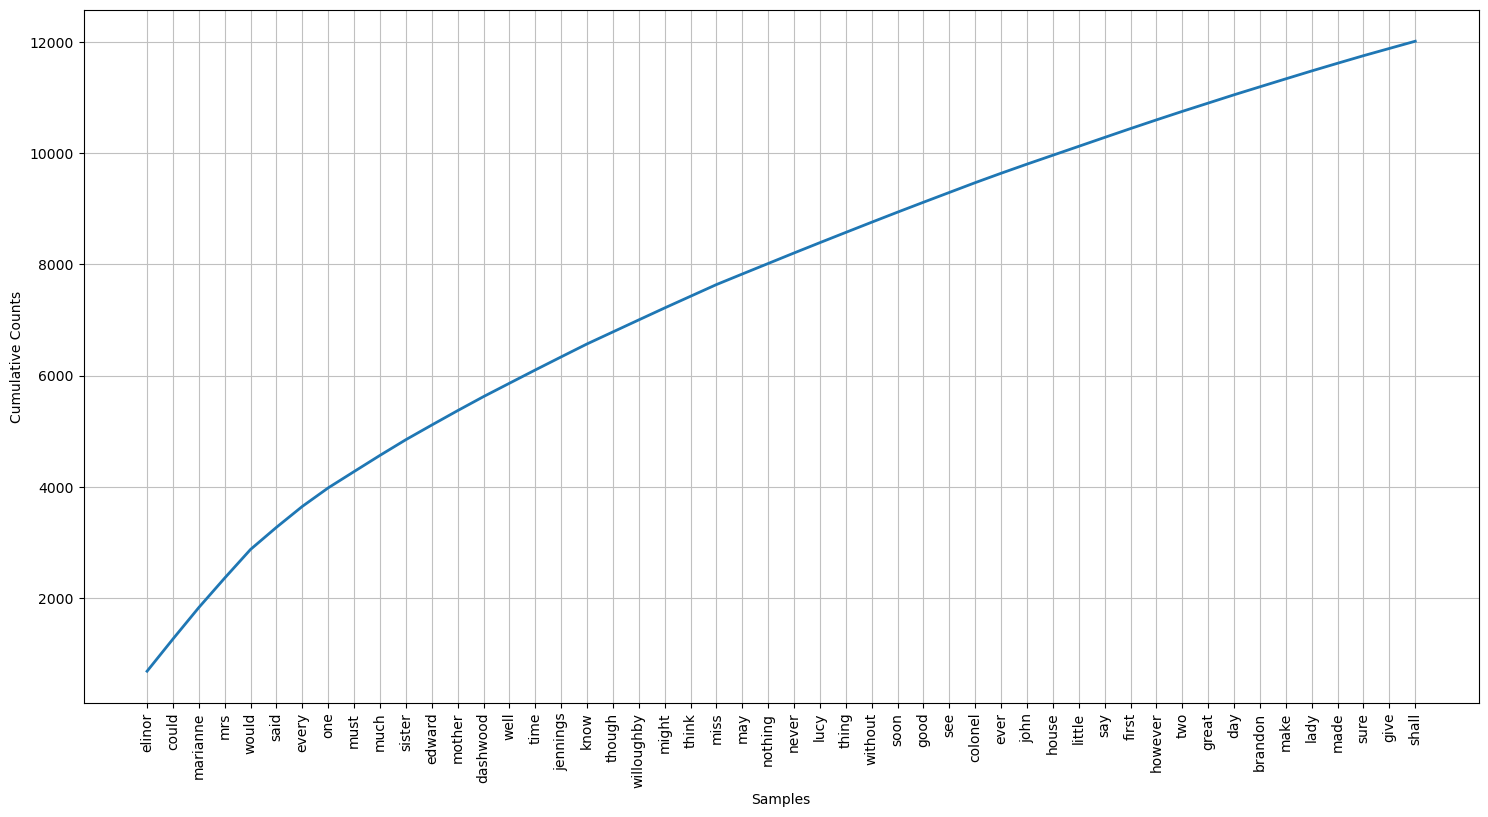

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [22]:
# Cumulative visualization of 50 most frequent words
plt.figure(figsize=(18,9))
f_dist.plot(50, cumulative=True)

### Performing Vader sentiment analysis

In [23]:
# Initialize Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [24]:
# Perform Vader sentiment analyzer
sentences['compound'] = [analyzer.polarity_scores(x)['compound'] for x in sentences['sentence']]
sentences['neg'] = [analyzer.polarity_scores(x)['neg'] for x in sentences['sentence']]
sentences['neu'] = [analyzer.polarity_scores(x)['neu'] for x in sentences['sentence']]
sentences['pos'] = [analyzer.polarity_scores(x)['pos'] for x in sentences['sentence']]
sentences.head(10)
# Negative: -1 --> Neutral: 0 --> Positive: +1

,sentence,compound,neg,neu,pos
0,A continuance in a place where everything remi...,0.5994,0.000,0.794,0.206
1,"In seasons of cheerfulness, no temper could be...",0.9117,0.123,0.468,0.409
2,But in sorrow she must be equally carried away...,0.1154,0.145,0.695,0.160
3,Mrs. John Dashwood did not at all approve of w...,0.0000,0.000,1.000,0.000
4,To take three thousand pounds from the fortune...,-0.1513,0.124,0.775,0.101
5,She begged him to think again on the subject.,0.0000,0.000,1.000,0.000
6,How could he answer it to himself to rob his c...,-0.5574,0.159,0.841,0.000
7,And what possible claim could the Miss Dashwoo...,0.1280,0.100,0.814,0.087
8,It was very well known that no affection was e...,-0.2893,0.165,0.691,0.144
9,"“It was my father’s last request to me,” repli...",0.0000,0.000,1.000,0.000


In [25]:
# Get number of positive, neutral, and negative sentences
positive_sentence = sentences.loc[sentences['compound'] > 0]
negative_sentence = sentences.loc[sentences['compound'] < 0]
neutral_sentence = sentences.loc[sentences['compound'] == 0]

print(f"Sentences array shape: {sentences.shape}")
print(f"Positive sentences: {len(positive_sentence)}")
print(f"Negative sentences: {len(negative_sentence)}")
print(f"Neutral sentences: {len(neutral_sentence)}")


Sentences array shape: (5382, 5)
Positive sentences: 2495
Negative sentences: 1324
Neutral sentences: 1563


Text(0.5, 1.0, 'Vader sentiment results')

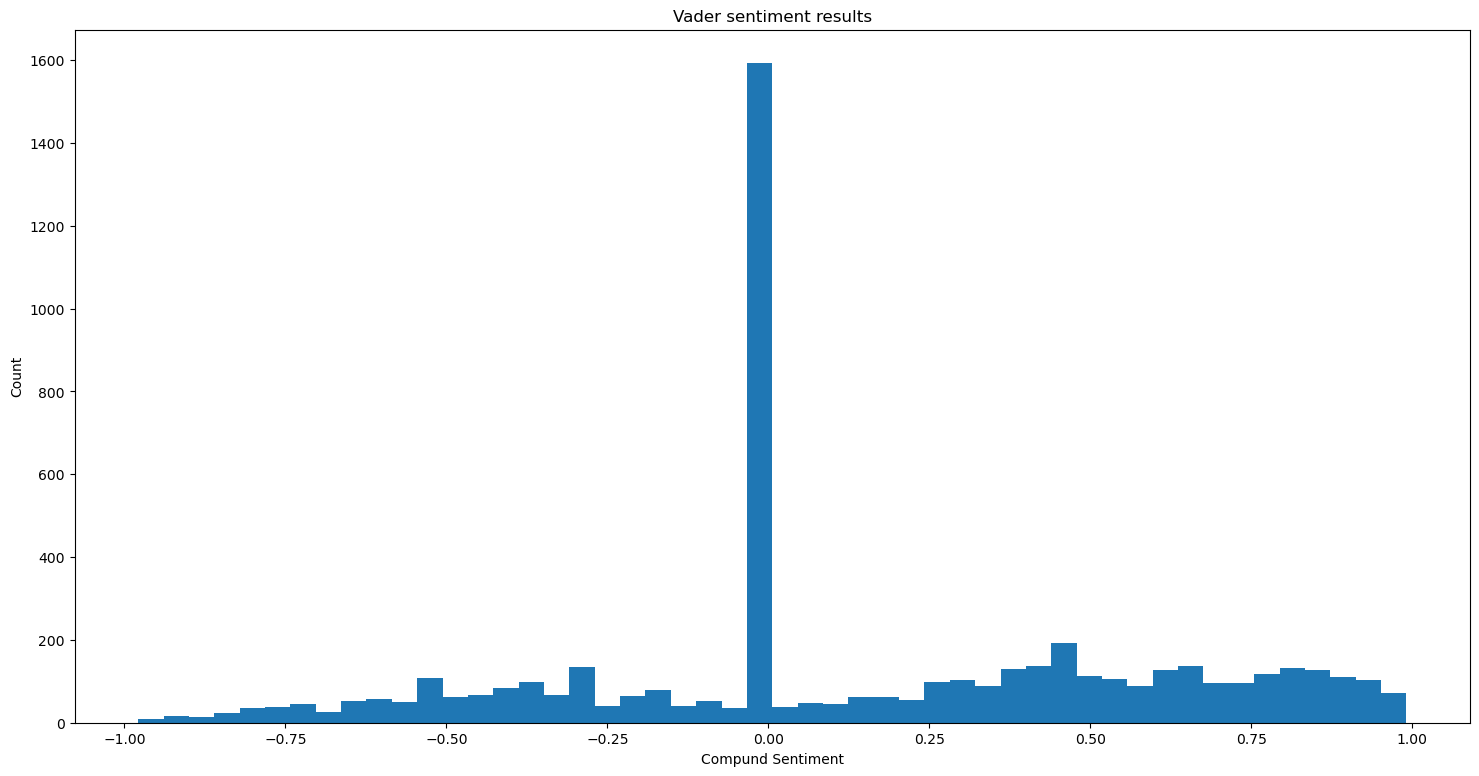

In [28]:
# Visualize Vader sentiment results
plt.figure(figsize=(18,9))
plt.hist(sentences['compound'], bins=50)
plt.xlabel("Compund Sentiment")
plt.ylabel("Count")
plt.title("Vader sentiment results")

### Building a Corpus and a Dictionary for Topic Modeling

In [29]:
# Convert sentence data to list
data = sentences['sentence'].values.tolist()
type(data)

list

In [30]:
# Text cleaning and tokenization using function
def text_processing(texts): 
    # Remove numbers and alphanumerical words we don't need
    texts = [re.sub ("[^a-zA-Z]+", " ", str(text)) for text in texts]
    # Tokenize & lowercase each word
    texts = [[word for word in text.lower().split()] for text in texts]
    # Stem each word
    lmtzr = WordNetLemmatizer()
    texts = [[lmtzr.lemmatize (word) for word in text] for text in texts] 
    # Remove stopwords
    stoplist = stopwords.words('english')
    texts = [[word for word in text if word not in stoplist] for text in texts]
    # Remove short words less than 3 letters in length
    texts = [[word for word in tokens if len(word) >= 3] for tokens in texts] 
    return texts

In [31]:
# Apply function to process data and convert to dictionary
data = text_processing(data)
dictionary = Dictionary(data)
len(dictionary)

5814

In [32]:
# Create corpus for LDA analysis
corpus = [dictionary.doc2bow(text) for text in data]
len(corpus)

5382

### Performing Topic Modeling

##### Latent Dirichlet Allocation (LDA): A topic modelling algorithm used to determine what topics are popular in a set of text.

-5.722157302194077
-4.851349294852974
-5.1291545683978255
-5.609527467649063
-7.614811728098381
-6.5013321250345895
-6.770812259656077


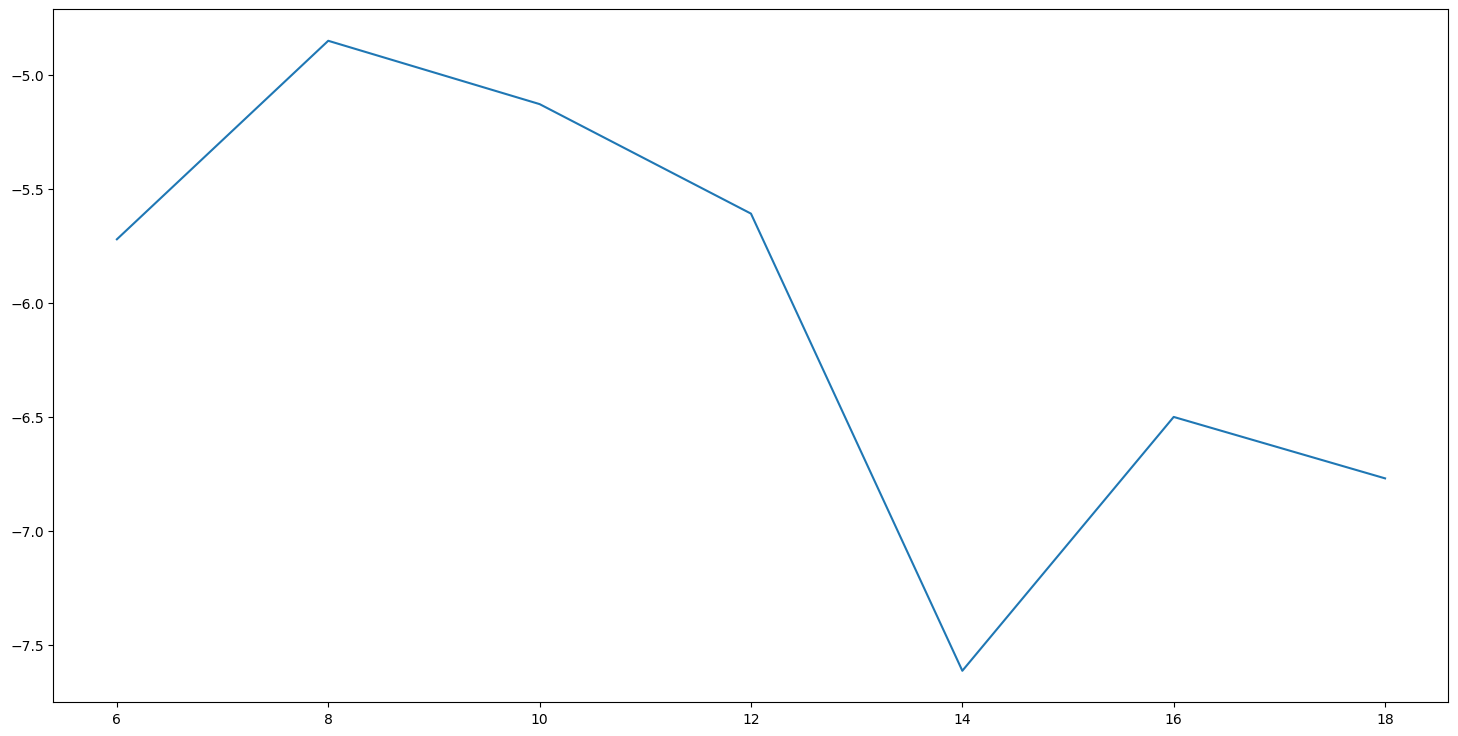

In [33]:
# Find optimal k value for the number of topics for our LDA analysis
np.random.seed(1)
k_range = range(6, 20, 2)
scores = []
for k in k_range:
    LdaModel = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, passes=20)
    cm = CoherenceModel(model=LdaModel, corpus=corpus, dictionary=dictionary, coherence="u_mass")
    print(cm.get_coherence())
    scores.append(cm.get_coherence())
plt.figure(figsize=(18,9))
plt.plot(k_range, scores)

In [34]:
# Build LDA topic model
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=6, passes=20)

In [35]:
# Print topic distribution
model.show_topics()

[(0,
  '0.013*"colonel" + 0.012*"elinor" + 0.010*"brandon" + 0.010*"marianne" + 0.009*"john" + 0.009*"ever" + 0.009*"could" + 0.008*"day" + 0.008*"see" + 0.008*"jennings"'),
 (1,
  '0.023*"elinor" + 0.019*"would" + 0.014*"marianne" + 0.014*"well" + 0.013*"said" + 0.013*"jennings" + 0.012*"could" + 0.009*"lady" + 0.008*"house" + 0.007*"one"'),
 (2,
  '0.012*"may" + 0.012*"time" + 0.012*"shall" + 0.011*"said" + 0.010*"dashwood" + 0.009*"think" + 0.008*"miss" + 0.008*"sister" + 0.007*"without" + 0.006*"replied"'),
 (3,
  '0.019*"elinor" + 0.016*"marianne" + 0.011*"dear" + 0.010*"every" + 0.009*"mother" + 0.009*"edward" + 0.008*"would" + 0.007*"hope" + 0.007*"much" + 0.007*"always"'),
 (4,
  '0.020*"every" + 0.017*"could" + 0.014*"would" + 0.008*"elinor" + 0.008*"sister" + 0.008*"might" + 0.008*"marianne" + 0.007*"willoughby" + 0.007*"moment" + 0.007*"much"'),
 (5,
  '0.014*"gutenberg" + 0.013*"work" + 0.013*"project" + 0.012*"could" + 0.011*"must" + 0.011*"one" + 0.010*"know" + 0.009*"may